In [98]:
#Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from sklearn.metrics import precision_score
import re
import math
import os
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import SparseCategoricalAccuracy

train_files_192 = tf.io.gfile.glob('/kaggle/input/tpu-getting-started/tfrecords-jpeg-192x192/train/*.tfrec')
train_files_224 = tf.io.gfile.glob('/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/train/*.tfrec')
train_files_331 = tf.io.gfile.glob('/kaggle/input/tpu-getting-started/tfrecords-jpeg-331x331/train/*.tfrec')
train_files_512 = tf.io.gfile.glob('/kaggle/input/tpu-getting-started/tfrecords-jpeg-512x512/train/*.tfrec')

val_files_192 = tf.io.gfile.glob('/kaggle/input/tpu-getting-started/tfrecords-jpeg-192x192/val/*.tfrec')
val_files_224 = tf.io.gfile.glob('/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/*.tfrec')
val_files_331 = tf.io.gfile.glob('/kaggle/input/tpu-getting-started/tfrecords-jpeg-331x331/val/*.tfrec')
val_files_512 = tf.io.gfile.glob('/kaggle/input/tpu-getting-started/tfrecords-jpeg-512x512/val/*.tfrec')

test_files_192 = tf.io.gfile.glob('/kaggle/input/tpu-getting-started/tfrecords-jpeg-192x192/test/*.tfrec')
test_files_224 = tf.io.gfile.glob('/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/test/*.tfrec')
test_files_331 = tf.io.gfile.glob('/kaggle/input/tpu-getting-started/tfrecords-jpeg-331x331/test/*.tfrec')
test_files_512 = tf.io.gfile.glob('/kaggle/input/tpu-getting-started/tfrecords-jpeg-512x512/test/*.tfrec')

train_files = train_files_512# + train_files_224 + train_files_331 + train_files_512
val_files = val_files_512 #+ val_files_224 + val_files_331 + val_files_512
test_files = test_files_512#+ test_files_224 + test_files_331 + test_files_512

#Settings
image_size = (512, 512) #other sizes 224x224, 331x331, 192x192
classes = ['pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 'wild geranium', 'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 'globe thistle',
           'snapdragon', "colt's foot", 'king protea', 'spear thistle', 'yellow iris', 'globe-flower', 'purple coneflower', 'peruvian lily', 'balloon flower', 'giant white arum lily',
           'fire lily', 'pincushion flower', 'fritillary', 'red ginger', 'grape hyacinth', 'corn poppy', 'prince of wales feathers', 'stemless gentian', 'artichoke', 'sweet william',
           'carnation', 'garden phlox', 'love in the mist', 'cosmos', 'alpine sea holly', 'ruby-lipped cattleya', 'cape flower', 'great masterwort', 'siam tulip', 'lenten rose',
           'barberton daisy', 'daffodil', 'sword lily', 'poinsettia', 'bolero deep blue', 'wallflower', 'marigold', 'buttercup', 'daisy', 'common dandelion',
           'petunia', 'wild pansy', 'primula', 'sunflower', 'lilac hibiscus', 'bishop of llandaff', 'gaura', 'geranium', 'orange dahlia', 'pink-yellow dahlia',
           'cautleya spicata', 'japanese anemone', 'black-eyed susan', 'silverbush', 'californian poppy', 'osteospermum', 'spring crocus', 'iris', 'windflower', 'tree poppy',
           'gazania', 'azalea', 'water lily', 'rose', 'thorn apple', 'morning glory', 'passion flower', 'lotus', 'toad lily', 'anthurium',
           'frangipani', 'clematis', 'hibiscus', 'columbine', 'desert-rose', 'tree mallow', 'magnolia', 'cyclamen', 'watercress', 'canna lily',
           'hippeastrum', 'bee balm', 'pink quill', 'foxglove', 'bougainvillea', 'camellia', 'mallow', 'mexican petunia', 'bromelia', 'blanket flower',
           'trumpet creeper', 'blackberry lily', 'common tulip', 'wild rose']
n_classes = len(classes)
features = {
    "image": tf.io.FixedLenFeature([], tf.string),
    "class": tf.io.FixedLenFeature([], tf.int64)
}
epochs = 15 #Keep 15-16 as a default
#Run processes in parallel
auto = tf.data.AUTOTUNE

**Connecting to the TPU**

In [6]:
#Connect to TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.TPUStrategy(tpu)
batch_size = 16 * strategy.num_replicas_in_sync

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU

**Getting Data**

In [91]:
#Train and validation
def read_tfrecord(record):
    features = {"image": tf.io.FixedLenFeature([], tf.string),
                "class": tf.io.FixedLenFeature([], tf.int64)}
    record = tf.io.parse_single_example(record, features)
    image = decode_image(record['image'])
    label = tf.cast(record['class'], tf.int32)
    return image, label

#Test files
def read_unlabeled_tfrecord(record):
    features = {"image": tf.io.FixedLenFeature([], tf.string),
                "id": tf.io.FixedLenFeature([], tf.string)}
    record = tf.io.parse_single_example(record, features)
    image = decode_image(record['image'])
    idnum = tf.cast(record['id'], tf.int32)
    return image, idnum

#Image data to image
def decode_image(data):
    image = tf.image.decode_jpeg(data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, [512, 512, 3])
    return image 

#Should help the models
def image_augment(image, label):
    image = tf.image.random_flip_left_right(image)
    return image,label


#Training data 
def get_train(ordered=False):
    dataset = load_dataset(train_files, labeled=True)
    dataset = dataset.map(image_augment, num_parallel_calls=auto)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(1024)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(auto)
    return dataset
    
    
#validation data
def get_val(ordered=False):
    dataset = load_dataset(val_files, labeled=True, ordered=ordered)
    dataset = dataset.batch(batch_size)
    dataset = dataset.cache()
    dataset = dataset.prefetch(auto)
    return dataset


#Test data
def get_test(ordered=False):
    dataset = load_dataset(test_files, labeled=False, ordered=ordered)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(auto)
    return dataset

#data load
def load(files, labeled=True, ordered=False):
    ignore = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False
    dataset = tf.data.TFRecordDataset(files, num_parallel_reads=auto)
    dataset = dataset.with_options(ignore)
    dataset = dataset.map(read_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=auto)
    return dataset

#found this neat way to count
def count(files):
    n = [int(re.compile(r"-([0-9]*)\.").search(files).group(1)) for file in files]
    return np.sum(n)


train = get_train()
val = get_val()
test = get_test()

train_num = count_data_items(train_files)
val_num = count_data_items(val_files)
test_num = count_data_items(test_files)

**CNN MODEL USING RESNET 50**

In [92]:
with strategy.scope():
    pretrained_model = tf.keras.applications.resnet50.ResNet50(
        weights='imagenet',
        include_top=False ,
        input_shape=[*image_size, 3]
    )
    pretrained_model.trainable = True
    model = tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(classes), activation='softmax')
    ])
model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
)
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 16, 16, 2048)      23587712  
                                                                 
 global_average_pooling2d_4  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 104)               213096    
                                                                 
Total params: 23800808 (90.79 MB)
Trainable params: 23747688 (90.59 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


**Learning Rate (Exponential)**

In [93]:
def exponential_lr(epoch, start_lr = 0.00001, min_lr = 0.00001, max_lr = 0.00005, rampup_epochs = 5, sustain_epochs = 0, exp_decay = 0.8):
    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        # Start is linear increase
        if epoch < rampup_epochs:
            lr = ((max_lr - start_lr) / rampup_epochs * epoch + start_lr)
            
        
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        # expontential
        else:
            lr = ((max_lr - min_lr) * exp_decay**(epoch - rampup_epochs - sustain_epochs) + min_lr)
        return lr
    return lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay)

lr_callback = tf.keras.callbacks.LearningRateScheduler(exponential_lr, verbose=True)

**Training the model**

In [94]:
with strategy.scope():
    steps = train_num // batch_size
    history = model.fit(train, validation_data=val, epochs=epochs, steps_per_epoch=steps, callbacks=[lr_callback])


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/15


2023-12-14 07:37:34.720847: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


99/99 [==============================] - ETA: 0s - loss: 1.9279 - sparse_categorical_accuracy: 0.5404

2023-12-14 07:39:20.131846: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


99/99 [==============================] - 146s 893ms/step - loss: 1.9279 - sparse_categorical_accuracy: 0.5404 - val_loss: 97.2823 - val_sparse_categorical_accuracy: 0.0213 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0008100000379979611.
Epoch 2/15
99/99 [==============================] - 73s 737ms/step - loss: 0.7704 - sparse_categorical_accuracy: 0.7928 - val_loss: 6.6631 - val_sparse_categorical_accuracy: 0.0329 - lr: 8.1000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0005060000335611404.
Epoch 3/15
99/99 [==============================] - 75s 757ms/step - loss: 0.4237 - sparse_categorical_accuracy: 0.8874 - val_loss: 5.6446 - val_sparse_categorical_accuracy: 0.0442 - lr: 5.0600e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.00023240000449121004.
Epoch 4/15
99/99 [==============================] - 74s 751ms/step - loss: 0.2079 - sparse_categorical_accuracy: 0.9464 - val_loss: 5.7231 - val_sparse_categorical_accuracy: 0.05

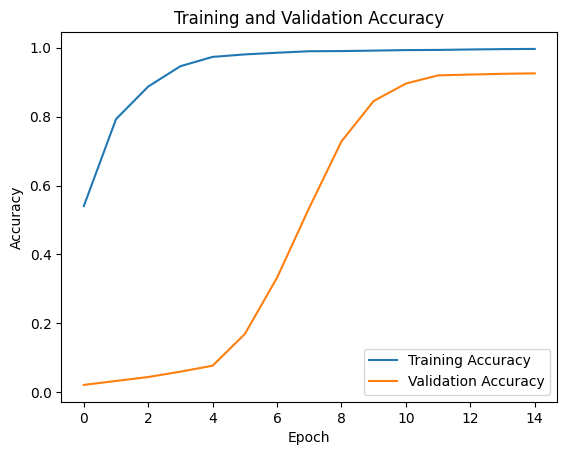

In [95]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['sparse_categorical_accuracy']
val_accuracy = history.history['val_sparse_categorical_accuracy']
plt.subplot(1, 1, 1)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [96]:
with strategy.scope():
    val_ordered = get_val(ordered=True)
    imgs = val_ordered.map(lambda image, label:image)
    lbls = val_ordered.map(lambda image, label:label).unbatch()
    val_correct = next(iter(lbls.batch(val_num))).numpy()
    probs = model.predict(imgs)
    pred = np.argmax(probs, axis=-1)
    clss = range(len(classes))
    precision = precision_score(
        val_correct, pred, labels=clss, average="macro"
    )
print(precision)

2023-12-14 07:57:28.887348: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


29/29 [==============================] - 20s 353ms/step
0.9223875176373564


**FNN Model**

In [100]:
with strategy.scope():
    fnn_model = models.Sequential([
        layers.Flatten(input_shape=(*image_size, 3)),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(n_classes, activation='softmax')
    ])
    fnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
fnn_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 786432)            0         
                                                                 
 dense_6 (Dense)             (None, 128)               100663424 
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 104)               13416     
                                                                 
Total params: 100676840 (384.05 MB)
Trainable params: 100676840 (384.05 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [101]:
with strategy.scope():
    history = fnn_model.fit(train, validation_data=val, epochs=epochs, steps_per_epoch=steps, callbacks=[lr_callback])


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/15


2023-12-14 07:59:15.220136: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


99/99 [==============================] - 64s 568ms/step - loss: 18.9888 - sparse_categorical_accuracy: 0.0563 - val_loss: 4.5985 - val_sparse_categorical_accuracy: 0.0582 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0008100000379979611.
Epoch 2/15
99/99 [==============================] - 55s 560ms/step - loss: 4.5776 - sparse_categorical_accuracy: 0.0589 - val_loss: 4.5582 - val_sparse_categorical_accuracy: 0.0582 - lr: 8.1000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0005060000335611404.
Epoch 3/15
99/99 [==============================] - 55s 560ms/step - loss: 4.5442 - sparse_categorical_accuracy: 0.0578 - val_loss: 4.5346 - val_sparse_categorical_accuracy: 0.0582 - lr: 5.0600e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.00023240000449121004.
Epoch 4/15
99/99 [==============================] - 56s 568ms/step - loss: 4.5272 - sparse_categorical_accuracy: 0.0575 - val_loss: 4.5240 - val_sparse_categorical_accuracy: 0.058

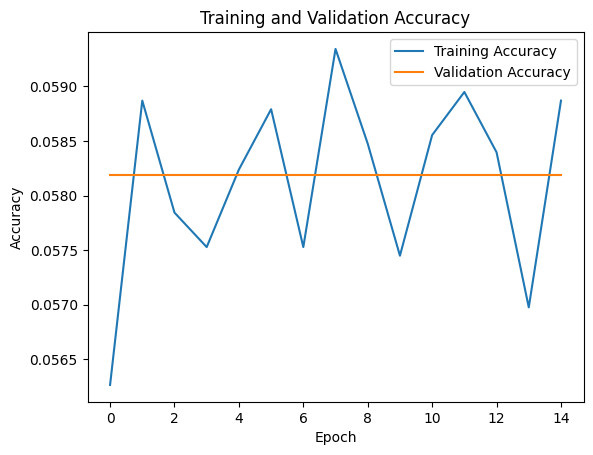

In [102]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['sparse_categorical_accuracy']
val_accuracy = history.history['val_sparse_categorical_accuracy']
plt.subplot(1, 1, 1)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [103]:
with strategy.scope():
    val_ordered = get_val(ordered=True)
    imgs = val_ordered.map(lambda image, label:image)
    lbls = val_ordered.map(lambda image, label:label).unbatch()
    val_correct = next(iter(lbls.batch(val_num))).numpy()
    probs = fnn_model.predict(imgs)
    pred = np.argmax(probs, axis=-1)
    clss = range(len(classes))
    precision = precision_score(
        val_correct, pred, labels=clss, average="macro")
print(precision)

2023-12-14 08:13:50.808856: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


29/29 [==============================] - 12s 339ms/step
0.0005595159151193633


/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
